In [1]:
import dynamax
from functools import partial

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from jax import vmap
from jax.nn import one_hot
import optax

from dynamax.hidden_markov_model import LogisticRegressionHMM, CategoricalHMM

## Inference

In [2]:
initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.95, 0.05], [0.10, 0.90]])
emission_probs = jnp.array(
    [
        [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
        [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],
    ]
)  # loaded die

print(f"A.shape: {transition_matrix.shape}")
print(f"B.shape: {emission_probs.shape}")

A.shape: (2, 2)
B.shape: (2, 6)


In [3]:
num_states = 2  # two types of dice (fair and loaded)
num_emissions = 1  # only one die is rolled at a time
num_classes = 6  # each die has six faces

# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(
    initial_probs=initial_probs,
    transition_matrix=transition_matrix,
    emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes),
)

In [9]:
num_timesteps = 300
true_states, emissions = hmm.sample(params, jr.PRNGKey(42), num_timesteps)

print(f"true_states.shape: {true_states.shape}")
print(f"emissions.shape: {emissions.shape}")
print("")
print("First few states:    ", true_states[:5])
print("First few emissions: ", emissions[:5, 0])

true_states.shape: (300,)
emissions.shape: (300, 1)

First few states:     [1 1 1 1 1]
First few emissions:  [5 0 5 5 5]


In [14]:
# To sample multiple sequences, just use vmap
num_batches = 5

batch_states, batch_emissions = vmap(
    partial(hmm.sample, params, num_timesteps=num_timesteps)
)(jr.split(jr.PRNGKey(0), num_batches))

print(f"batch_states.shape: {batch_states.shape}")
print(f"batch_emissions.shape: {batch_emissions.shape}")

batch_states.shape: (5, 300)
batch_emissions.shape: (5, 300, 1)


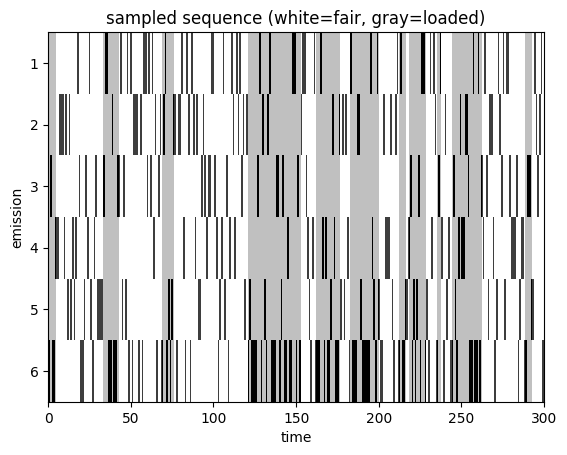

In [15]:
def plot_sequence(states, emissions):
    plt.imshow(
        one_hot(emissions[:, 0], 6).T, aspect="auto", interpolation="none", cmap="Greys"
    )
    plt.imshow(
        states[None, :],
        extent=(0, num_timesteps, num_classes - 0.5, -0.5),
        interpolation="none",
        aspect="auto",
        cmap="Greys",
        alpha=0.25,
    )
    plt.xlabel("time")
    plt.ylabel("emission")
    plt.yticks(jnp.arange(6), jnp.arange(6) + 1)  # b/c python is zero indexed!
    plt.title("sampled sequence (white=fair, gray=loaded)")


plot_sequence(batch_states[0], batch_emissions[0])

In [16]:
# count fraction of times we see 6 in each state
# remember that python is zero-indexed, so we have to add one!
p0 = jnp.mean(emissions[true_states == 0] + 1 == 6)  # fair
p1 = jnp.mean(emissions[true_states == 1] + 1 == 6)  # loaded
print("empirical frequencies: ", jnp.array([p0, p1]))
print("expected frequencies:  ", emission_probs[:, -1])

empirical frequencies:  [0.14970061 0.46616542]
expected frequencies:   [0.16666667 0.5       ]


In [19]:
posterior = hmm.filter(params, emissions)
print(f"marginal likelihood: {posterior.marginal_loglik: .2f}")
print(f"posterior.filtered_probs.shape: {posterior.filtered_probs.shape}")

marginal likelihood: -517.95
posterior.filtered_probs.shape: (300, 2)


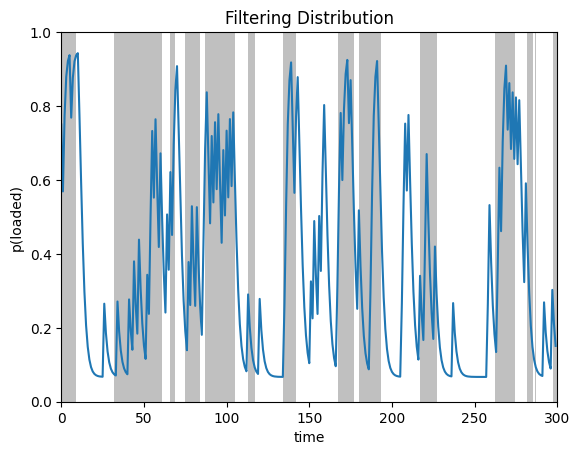

In [20]:
def plot_posterior_probs(probs, states, title=""):
    plt.imshow(
        states[None, :],
        extent=(0, num_timesteps, 0, 1),
        interpolation="none",
        aspect="auto",
        cmap="Greys",
        alpha=0.25,
    )
    plt.plot(probs[:, 1])  # probability of the loaded state (z=1)
    plt.xlabel("time")
    plt.ylabel("p(loaded)")
    plt.ylim(0, 1)
    plt.title(title)


plot_posterior_probs(
    posterior.filtered_probs, true_states, title="Filtering Distribution"
)

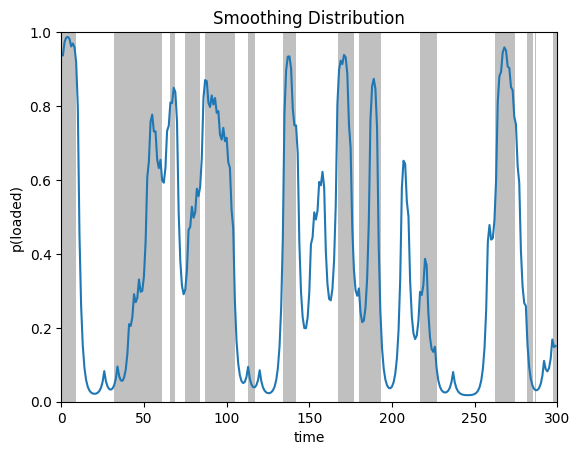

In [21]:
posterior = hmm.smoother(params, emissions)
plot_posterior_probs(
    posterior.smoothed_probs, true_states, title="Smoothing Distribution"
)

## Learning Parameters

In [34]:
num_states = 2  # two types of dice (fair and loaded)
num_emissions = 1  # only one die is rolled at a time
num_classes = 6  # each die has six faces

initial_probs = jnp.array([0.5, 0.5])
transition_matrix = jnp.array([[0.95, 0.05], [0.10, 0.90]])
emission_probs = jnp.array(
    [
        [1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6, 1 / 6],  # fair die
        [1 / 10, 1 / 10, 1 / 10, 1 / 10, 1 / 10, 5 / 10],
    ]
)  # loaded die


# Construct the HMM
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

# Initialize the parameters struct with known values
params, _ = hmm.initialize(
    initial_probs=initial_probs,
    transition_matrix=transition_matrix,
    emission_probs=emission_probs.reshape(num_states, num_emissions, num_classes),
)

num_batches = 5
num_timesteps = 5000
hmm = CategoricalHMM(num_states, num_emissions, num_classes)

batch_states, batch_emissions = vmap(
    partial(hmm.sample, params, num_timesteps=num_timesteps)
)(jr.split(jr.PRNGKey(42), num_batches))

print(f"batch_states.shape:    {batch_states.shape}")
print(f"batch_emissions.shape: {batch_emissions.shape}")

batch_states.shape:    (5, 5000)
batch_emissions.shape: (5, 5000, 1)


In [35]:
def print_params(params):
    jnp.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
    print("initial probs:")
    print(params.initial.probs)
    print("transition matrix:")
    print(params.transitions.transition_matrix)
    print("emission probs:")
    print(params.emissions.probs[:, 0, :])  # since num_emissions = 1


print_params(params)

initial probs:
[0.500 0.500]
transition matrix:
[[0.950 0.050]
 [0.100 0.900]]
emission probs:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.100 0.100 0.100 0.100 0.100 0.500]]


The first step is to randomly initialize new parameters. You can do that by calling hmm.initialize(key), where key is a JAX pseudorandom number generator (PRNG) key. When no other keyword arguments are supplied, this function will return parameters randomly sampled from the prior.

Since we expect the states to persist for some time, we add a little stickiness to the prior distribution on transition probabilities via the transition_matrix_stickiness hyperparameter.

Notice that initialize returns two things, the parameters and their properties. Among other things, the properties allow you to specify which parameters should be learned. You can set the trainable flag to False if you want to fix certain parmeters.

In [36]:
hmm = CategoricalHMM(
    num_states, num_emissions, num_classes, transition_matrix_stickiness=10.0
)

key = jr.PRNGKey(0)
fbgd_params, fbgd_props = hmm.initialize(key)

print("Randomly initialized parameters")
print_params(fbgd_params)

Randomly initialized parameters
initial probs:
[0.793 0.207]
transition matrix:
[[0.978 0.022]
 [0.252 0.748]]
emission probs:
[[0.145 0.115 0.024 0.136 0.187 0.393]
 [0.010 0.119 0.416 0.325 0.068 0.061]]


### SGD

In [37]:
# Full batch gradient descent
fbgd_key, key = jr.split(key)
fbgd_params, fbgd_losses = hmm.fit_sgd(
    fbgd_params,
    fbgd_props,
    batch_emissions,
    optimizer=optax.sgd(learning_rate=1e-2, momentum=0.95),
    batch_size=num_batches,
    num_epochs=400,
    key=fbgd_key,
)
key = jr.PRNGKey(0)


# Stochastic gradient descent
sgd_params, sgd_param_props = hmm.initialize(key)
sgd_key, key = jr.split(key)
sgd_params, sgd_losses = hmm.fit_sgd(
    sgd_params,
    sgd_param_props,
    batch_emissions,
    optimizer=optax.sgd(learning_rate=1e-2, momentum=0.95),
    batch_size=2,
    num_epochs=400,
    key=sgd_key,
)

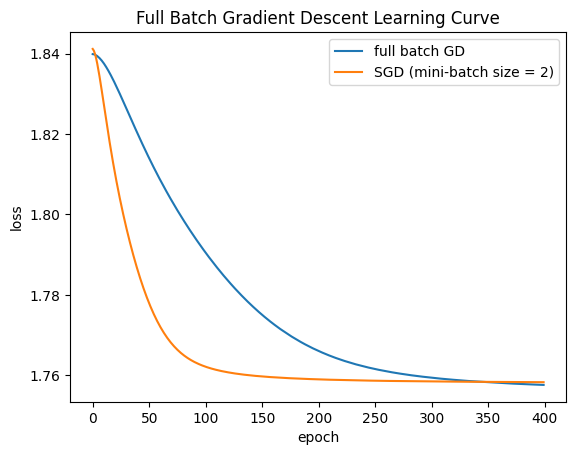

In [38]:
plt.plot(fbgd_losses, label="full batch GD")
plt.plot(sgd_losses, label="SGD (mini-batch size = 2)")
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.title("Full Batch Gradient Descent Learning Curve")

In [39]:
# Print the parameters after learning
print("Full batch gradient descent params:")
print_params(fbgd_params)
print("")
print("Stochastic gradient descent params:")
print_params(sgd_params)

Full batch gradient descent params:
initial probs:
[0.793 0.207]
transition matrix:
[[0.961 0.039]
 [0.292 0.708]]
emission probs:
[[0.162 0.142 0.115 0.131 0.145 0.306]
 [0.013 0.170 0.406 0.249 0.093 0.070]]

Stochastic gradient descent params:
initial probs:
[0.793 0.207]
transition matrix:
[[0.964 0.036]
 [0.344 0.656]]
emission probs:
[[0.165 0.143 0.124 0.130 0.150 0.287]
 [0.014 0.229 0.315 0.258 0.110 0.074]]


### Expectation Maximization

In [41]:
key = jr.PRNGKey(0)
em_params, em_param_props = hmm.initialize(key)
em_params, log_probs = hmm.fit_em(
    em_params, em_param_props, batch_emissions, num_iters=400
)

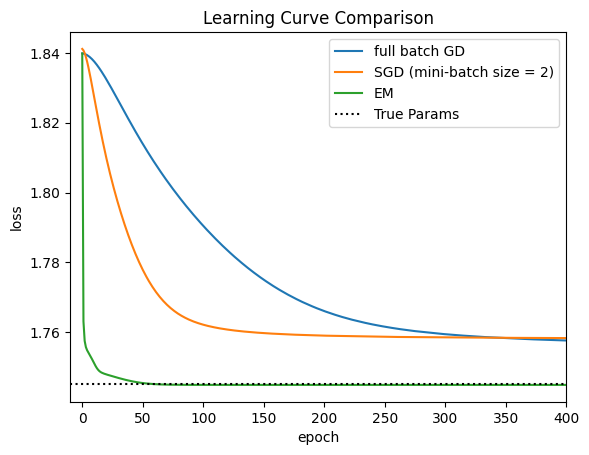

In [42]:
# Compute the "losses" from EM
em_losses = -log_probs / batch_emissions.size

# Compute the loss if you used the parameters that generated the data
true_loss = vmap(partial(hmm.marginal_log_prob, params))(batch_emissions).sum()
true_loss += hmm.log_prior(params)
true_loss = -true_loss / batch_emissions.size

# Plot the learning curves
plt.plot(fbgd_losses, label="full batch GD")
plt.plot(sgd_losses, label="SGD (mini-batch size = 2)")
plt.plot(em_losses, label="EM")
plt.axhline(true_loss, color="k", linestyle=":", label="True Params")
plt.legend()
plt.xlim(-10, 400)
plt.xlabel("epoch")
plt.ylabel("loss")
_ = plt.title("Learning Curve Comparison")

In [47]:
print("EM parameters")
print_params(em_params)

print("\nTrue Parameters")
print_params(params)

EM parameters
initial probs:
[0.628 0.372]
transition matrix:
[[0.909 0.091]
 [0.053 0.947]]
emission probs:
[[0.110 0.106 0.101 0.110 0.105 0.468]
 [0.171 0.173 0.171 0.164 0.164 0.157]]

True Parameters
initial probs:
[0.500 0.500]
transition matrix:
[[0.950 0.050]
 [0.100 0.900]]
emission probs:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.100 0.100 0.100 0.100 0.100 0.500]]


In [45]:
print_params(params)

initial probs:
[0.500 0.500]
transition matrix:
[[0.950 0.050]
 [0.100 0.900]]
emission probs:
[[0.167 0.167 0.167 0.167 0.167 0.167]
 [0.100 0.100 0.100 0.100 0.100 0.500]]


## Cross Validation- TODO update with Catagorical HMM

In [50]:
from dynamax.hidden_markov_model import GaussianHMM

num_train_batches = 3
num_test_batches = 1
num_timesteps = 100

# Make an HMM and sample data and true underlying states
true_num_states = 5
emission_dim = 2
hmm = GaussianHMM(true_num_states, emission_dim)

# Specify parameters of the HMM
initial_probs = jnp.ones(true_num_states) / true_num_states
transition_matrix = (
    0.80 * jnp.eye(true_num_states)
    + 0.15 * jnp.roll(jnp.eye(true_num_states), 1, axis=1)
    + 0.05 / true_num_states
)
emission_means = jnp.column_stack(
    [
        jnp.cos(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
        jnp.sin(jnp.linspace(0, 2 * jnp.pi, true_num_states + 1))[:-1],
        jnp.zeros((true_num_states, emission_dim - 2)),
    ]
)
emission_covs = jnp.tile(0.1**2 * jnp.eye(emission_dim), (true_num_states, 1, 1))

true_params, _ = hmm.initialize(
    initial_probs=initial_probs,
    transition_matrix=transition_matrix,
    emission_means=emission_means,
    emission_covariances=emission_covs,
)

# Sample train, validation, and test data
train_key, val_key, test_key = jr.split(jr.PRNGKey(0), 3)
f = vmap(partial(hmm.sample, true_params, num_timesteps=num_timesteps))
train_true_states, train_emissions = f(jr.split(train_key, num_train_batches))
test_true_states, test_emissions = f(jr.split(test_key, num_test_batches))

In [51]:
def cross_validate_model(model, key, num_iters=100):
    # Initialize the parameters using K-Means on the full training set
    params, props = model.initialize(
        key=key, method="kmeans", emissions=train_emissions
    )

    # Split the training data into folds.
    # Note: this is memory inefficient but it highlights the use of vmap.
    folds = jnp.stack(
        [
            jnp.concatenate([train_emissions[:i], train_emissions[i + 1 :]])
            for i in range(num_train_batches)
        ]
    )

    def _fit_fold(y_train, y_val):
        fit_params, train_lps = model.fit_em(
            params, props, y_train, num_iters=num_iters, verbose=False
        )
        return model.marginal_log_prob(fit_params, y_val)

    val_lls = vmap(_fit_fold)(folds, train_emissions)
    return val_lls.mean(), val_lls

In [52]:
# Make a range of Gaussian HMMs
all_num_states = list(range(2, 10))
test_hmms = [
    GaussianHMM(num_states, emission_dim, transition_matrix_stickiness=10.0)
    for num_states in all_num_states
]
results = []
for test_hmm in test_hmms:
    print(f"fitting model with {test_hmm.num_states} states")
    results.append(cross_validate_model(test_hmm, jr.PRNGKey(0)))

avg_val_lls, all_val_lls = tuple(zip(*results))

fitting model with 2 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 3 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 4 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 5 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 6 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 7 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 8 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


fitting model with 9 states


/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Text(0, 0.5, 'avg. validation log prob.')

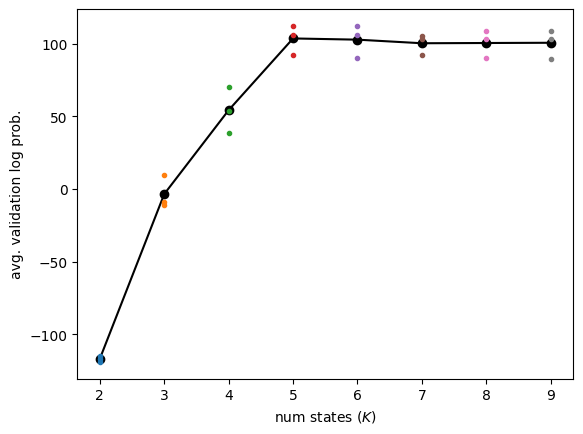

In [53]:
plt.plot(all_num_states, avg_val_lls, "-ko")
for k, per_fold_val_lls in zip(all_num_states, all_val_lls):
    plt.plot(k * jnp.ones_like(per_fold_val_lls), per_fold_val_lls, ".")
plt.xlabel("num states ($K$)")
plt.ylabel("avg. validation log prob.")

In [54]:
best_num_states = all_num_states[jnp.argmax(jnp.stack(avg_val_lls))]
print("best number of states:", best_num_states)

best number of states: 5
